# Kaggle: Customer Transaction Prediction

## Feature Engineering

First, I import the necessary models and the train and test datasets from Kaggle. Throughout the feature engineering process I run a baseline logistic regression model to check the change in baseline perfomance after each large change in feature engineering, I might therefore reference to this throughout the notebook.

### Import Modules

In [29]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from scipy.stats import kurtosis, skew

### Import Data

In [5]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

### Inspecting the Data

We will print the heads of both the train and test sets to see what they consist of. The train and test datasets each contain 200k records with 200 features. Only the train dataset contains the target.

In [6]:
print(train.shape)
train.head()

(200000, 202)


,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


In [7]:
print(test.shape)
test.head()

(200000, 201)


,ID_code,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,test_0,11.0656,7.7798,12.9536,9.4292,11.4327,-2.3805,5.8493,18.2675,2.1337,...,-2.1556,11.8495,-1.4300,2.4508,13.7112,2.4669,4.3654,10.7200,15.4722,-8.7197
1,test_1,8.5304,1.2543,11.3047,5.1858,9.1974,-4.0117,6.0196,18.6316,-4.4131,...,10.6165,8.8349,0.9403,10.1282,15.5765,0.4773,-1.4852,9.8714,19.1293,-20.9760
2,test_2,5.4827,-10.3581,10.1407,7.0479,10.2628,9.8052,4.8950,20.2537,1.5233,...,-0.7484,10.9935,1.9803,2.1800,12.9813,2.1281,-7.1086,7.0618,19.8956,-23.1794
3,test_3,8.5374,-1.3222,12.0220,6.5749,8.8458,3.1744,4.9397,20.5660,3.3755,...,9.5702,9.0766,1.6580,3.5813,15.1874,3.1656,3.9567,9.2295,13.0168,-4.2108
4,test_4,11.7058,-0.1327,14.1295,7.7506,9.1035,-8.5848,6.8595,10.6048,2.9890,...,4.2259,9.1723,1.2835,3.3778,19.5542,-0.2860,-5.1612,7.2882,13.9260,-9.1846


### Inspecting the Target

We will now plot the distribution of the target variable.

<AxesSubplot:xlabel='target', ylabel='count'>

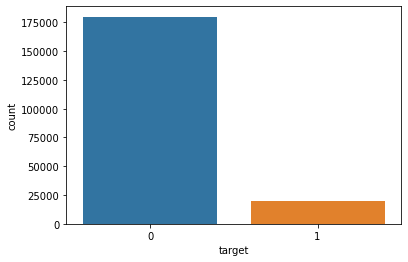

In [8]:
sns.countplot(x=train.target)

The classes are highly imbalanced so we might probably benefit from doing something about that. I tried oversampling the data using SMOTE but it significantly reduced the accuracy of the baseline model. Hence, we will leave the class imbalance like this for now.

In [9]:
#To deal with the class imbalance of the target variable we will use SMOTE, a method of oversampling the data.
#from imblearn.over_sampling import SMOTE
#smote = SMOTE() 
#train, y = smote.fit_resample(train.drop(["ID_code", "target"], axis=1), train.target)
#train["target"] = y
#sns.countplot(x=train.target)

### Merging the Train and Test Sets

Next, we will merge train and test to a dataframe that we will use to preprocess both simultaneously. We save the train and test ids so we will be able to reconstruct train and test later by subsetting full. We also need the ids for the submission to Kaggle. We also save and drop the target from the full dataset, as it is only present in the train set. We also drop the ID column because we will not need it at this point.

In [10]:
train_id = train["ID_code"]
test_id = test["ID_code"]
y_train = train.target.values
full = pd.concat([train, test])
full = full.drop(["target", "ID_code"], axis=1)

In [11]:
full.head()

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,-4.9200,5.7470,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,3.1468,8.0851,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,-4.9193,5.9525,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,-5.8609,8.2450,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,6.2654,7.6784,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


### Checking for High Multicollinearity

As there are so many features, it becomes hard to visualize all of their correlations in a heatmap. Hence, to see if there are high multicollinearity issues (correlation > 0.80) we calculate the number of values with a high multicollinearity in the correlation dataframe and subtract the number of features. We subtract the number of features because for each feature there is a correlation of 1 with itself, which will be counted as a correlation of > 0.80. The output is 0 so there do not seem to be any multicollinearity issues.

In [13]:
corr = full.corr()
high_corr = np.sum(np.sum(corr > 0.80)) - full.shape[1]
print("There are {} correlations higher than 0.80.".format(high_corr))

There are 0 correlations higher than 0.80.


### Checking for Missing Values

Next, we will check for missing values. There seem to be no missing values and nothing seems to be described on the Kaggle page about missing values, therefore, we will assume there are none at this point.

In [14]:
missing_vals = np.sum(np.sum(full.isna()))
print("There are {} missing values in the data.".format(missing_vals))

There are 0 missing values in the data.


### Checking for Skewed Predictors

We will now check if there are any skewed predictors. We will do this by creating a dataframe containing all skewness and kurtosis values for each feature. We then subset the dataframe to get the features that have skewness or kurtosis of less than -2 or more than 2. There neither are any features with high skewness nor features with high kurtosis, meaning we can assume all features are approximately normally distributed. Consequently, we do not have to worry about normalizing the data.

In [28]:
sk = [full[feature].skew() for feature in full]
ku = [full[feature].kurt() for feature in full]
feature = [feature for feature in full]
skew_df = pd.DataFrame([feature,sk,ku]).T
skew_df.columns = ["feature","skewness","kurtosis"]
high_skew = skew_df[(skew_df["skewness"] > 2) | (skew_df["skewness"] < -2)]
high_kurt = skew_df[(skew_df["kurtosis"] > 2) | (skew_df["kurtosis"] < -2)]
print("The data contains {} features with high skewness.".format(len(high_skew)))
print("The data contains {} features with high kurtosis.".format(len(high_kurt)))

The data contains 0 features with high skewness.
The data contains 0 features with high kurtosis.


In [35]:
skew_df.sort_values("skewness")

,feature,skewness,kurtosis
44,var_44,-0.334506,-0.10699
93,var_93,-0.241298,-0.145538
81,var_81,-0.233976,-0.197273
86,var_86,-0.217701,-0.241528
80,var_80,-0.215633,-0.401235
...,...,...,...
0,var_0,0.230559,-0.269209
163,var_163,0.238993,-0.345985
179,var_179,0.245241,-0.018888
2,var_2,0.261597,-0.327915


### Standardizing the Data

Next, we will standardize the data. The values of the features are not extremely large but it might help nonetheless. There was a slight increase in baseline performance due to the standardization. 

In [31]:
scaler = StandardScaler()
full = scaler.fit_transform(full)

### Reconstructing Train and Test

Now that we have applied and tested all preprocessing on the full dataset, we are ready to reconstruct our train and test set in the form of numpy arrays so we can use them as inputs in the modelling process.

In [ ]:
#X_train = train.drop(["target"], axis=1).values
#y_train = train.target.values
#X_test = test.drop(["ID_code"], axis=1).values

In [33]:
X_train = full[:len(train_id)]
X_test = full[len(train_id):]

### Logistic Regression (Baseline Model)

#### Feature Engineering Baseline Impacts
- score1: 0.911689999870584 No FE
- score2: 0.7875982554476241 After SMOTE
- score3: 0.9143250019957262 only standardization

In [34]:
reg = LogisticRegression()
cross_val_score(reg, X_train, y_train, cv=3, scoring="accuracy").mean()

0.9143250019957262

### SGD Classifier

As the dataset is quite large (>100k records), we might be better off using an algorithm that employs gradient descent. Sklearn's SGD Classifier is perfect for this situation as it allows us to use 